# Scaling

In [1]:
from cooltools.expected import logbin_expected, diagsum, combine_binned_expected
import cooler
import matplotlib.pyplot as plt
import pandas as pd
import multiprocess
import bioframe
import pickle
from scipy.interpolate import interp1d

#cooler, version 0.8.10
#Python 3.7.9


In [2]:
#naming 
pathDir = "/nl/umw_job_dekker/users/as38w/JZ2022_git/coolers"

conditions =[
    '1',
    '2'

]

short_names = {
    '1':'ND-DMSO',
    '2':'4OHT-DMSO'
}

long_names = {
    '1' : 'JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1',
    '2' : 'JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1'
  
}   

coolerfile = {}
for cond in conditions:
    coolerfile[cond] = '{}/{}.mm10.nodups.65M.1000.mcool::resolutions/1000'.format(pathDir, long_names[cond])
    
clrs = {
    cond: cooler.Cooler(coolerfile[cond]) for cond in conditions
}


In [3]:
clrs

{'1': <Cooler "JZ-MEF-AsiS1-ND-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::/resolutions/1000">,
 '2': <Cooler "JZ-MEF-AsiS1-4OHT-dmso6h-HiCD2R1.mm10.nodups.65M.1000.mcool::/resolutions/1000">}

In [7]:
"Step 1: Computing expected using diagsum"
RESOLUTION = clrs[cond].info["bin-size"]
exp={}

for cond in conditions:
    RESOLUTION = clrs[cond].info["bin-size"]
    
    #since we deal with mouse chromosomes I will ignore the arms
    chromsizes = bioframe.fetch_chromsizes("mm10")
    #ie. for Chr1,2:
    GOOD_CHROMS = list(chromsizes.index[0:2])
    
    with multiprocess.Pool(20) as pool:
        exp[cond] = diagsum(
            clrs[cond],
            GOOD_CHROMS,
            transforms={"balanced": lambda p: p["count"] * p["weight1"] * p["weight2"]},
            map=pool.map,
        )
        

In [8]:
"Step 2: binning expected. "

binned_exp={}
binned_slope={}
bins={}
scal={}
der={}


for cond in conditions:
# We need to logbin expected first - using default 10 bins per order magnitude
    binned_exp[cond], binned_slope[cond], bins[cond] = logbin_expected(exp[cond])

    scal[cond], der[cond] = combine_binned_expected(binned_exp[cond], binned_slope[cond], spread_funcs="logstd")
   

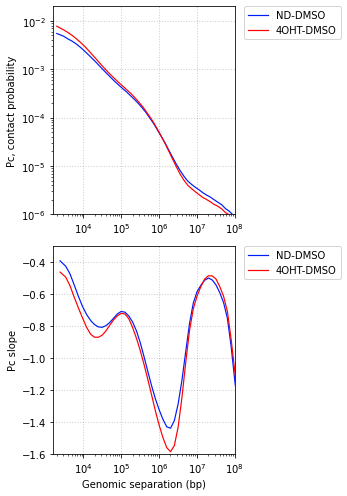

In [9]:
#fe0002:red
#021bf9:blue
plt.figure(figsize=(5, 7))

colors={'1':'#021bf9',
        '2':'#fe0002'
       }

linestyles={'1':'-',
            '2':'-'
       }

labels={'1':f'ND-DMSO',
        '2':f'4OHT-DMSO'
       }

# plotting actual Pc(s)
plt.subplot(211)
for cond in ['1', '2']:    
    scal[cond][["diag.avg.res"]]=scal[cond][["diag.avg"]] * RESOLUTION
    
    plt.plot(scal[cond][["diag.avg.res"]], scal[cond][["balanced.avg"]], label=labels[cond], ls=linestyles[cond], color=colors[cond],lw=1.2)
    
    plt.ylabel("Pc, contact probability")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.ylim(10**-6, 10**-1.7)
    plt.xlim(10**3.2, 10**8)
    plt.grid(which='major', axis='both', color='k', linestyle=':', linewidth=1, alpha=0.2)

# plotting derivative
plt.subplot(212)
for cond in ['1', '2']:
    plt.plot(der[cond][["diag.avg"]] * RESOLUTION, der[cond][["slope"]], label=labels[cond], ls=linestyles[cond], color=colors[cond],lw=1.2)
    plt.ylabel("Pc slope")
    plt.xlabel("Genomic separation (bp)")
    plt.xscale("log")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.ylim(-1.6, -0.3)
    plt.xlim(10**3.2, 10**8)
    plt.grid(which='major', axis='both', color='k', linestyle=':', linewidth=1, alpha=0.2)
    
plt.tight_layout()
#plt.savefig('*.pdf', dpi = 300, bbox_inches='tight')
    


In [10]:
for cond in conditions: 
    scal[cond][["diag.avg.res"]]=scal[cond][["diag.avg"]] * RESOLUTION
    der[cond][["diag.avg.res"]]=der[cond][["diag.avg"]] * RESOLUTION
    

In [11]:
#error shading for multiple chromosomes
#Pc
list_a=scal['1']
x_list_a=list_a["diag.avg.res"]
y_list_1a=list_a["low_err"]
y_list_2a=list_a["high_err"]

list_b=scal['2']
x_list_b=list_b["diag.avg.res"]
y_list_1b=list_b["low_err"]
y_list_2b=list_b["high_err"]

#derPc
dlist_a=der['1']
dx_list_a=dlist_a["diag.avg.res"]
dy_list_1a=dlist_a["low_err"]
dy_list_2a=dlist_a["high_err"]

dlist_b=der['2']
dx_list_b=dlist_b["diag.avg.res"]
dy_list_1b=dlist_b["low_err"]
dy_list_2b=dlist_b["high_err"]


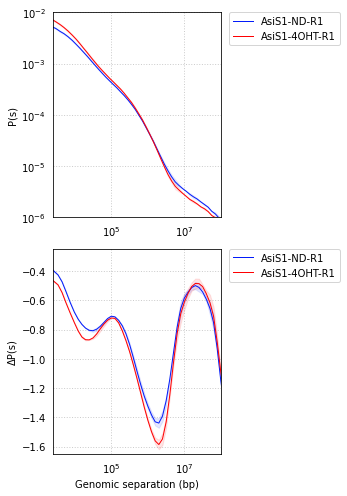

In [13]:
plt.figure(figsize=(5, 7))
#plt.figure(figsize=(7, 11))
#'#021bf9'
#'#fe0002'

# plotting actual Pc(s)
plt.subplot(211)
plt.plot(scal['1'][["diag.avg"]] * RESOLUTION, scal['1'][["balanced.avg"]], label='AsiS1-ND-R1', ls='-', lw='1', color='#021bf9')
plt.fill_between(x_list_a, y_list_1a, y_list_2a, color='#021bf9', alpha=0.07)
plt.plot(scal['2'][["diag.avg"]] * RESOLUTION, scal['2'][["balanced.avg"]], label='AsiS1-4OHT-R1', ls='-', lw='1', color='#fe0002')
plt.fill_between(x_list_b, y_list_1b, y_list_2b, color='#fe0002', alpha=0.07)


plt.ylabel("P(s)")
plt.xscale("log")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(10**-6, 10**-2)
plt.xlim(10**3.4, 10**8)
plt.grid(which='major', axis='both', color='k', linestyle=':', linewidth=1, alpha=0.2)
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

# plotting derivative
plt.subplot(212)
plt.plot(der['1'][["diag.avg"]] * RESOLUTION, der['1'][["slope"]], label='AsiS1-ND-R1', ls='-',lw='1', color='#021bf9')
plt.fill_between(dx_list_a, dy_list_1a, dy_list_2a, color='#021bf9', alpha=0.1)
plt.plot(der['2'][["diag.avg"]] * RESOLUTION, der['2'][["slope"]], label='AsiS1-4OHT-R1', ls='-',lw='1', color='#fe0002')
plt.fill_between(dx_list_b, dy_list_1b, dy_list_2b, color='#fe0002', alpha=0.1)

plt.ylabel("\u0394P(s)")
plt.xlabel("Genomic separation (bp)")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(-1.65, -0.25)
plt.xlim(10**3.4, 10**8)
plt.grid(which='major', axis='both', color='k', linestyle=':', linewidth=1, alpha=0.2)    
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False

plt.tight_layout()
#plt.savefig('*.pdf', dpi = 300, bbox_inches='tight')

